In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mcr_const
import math, os

%matplotlib inline

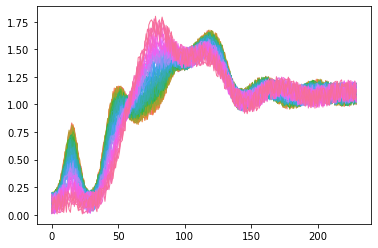

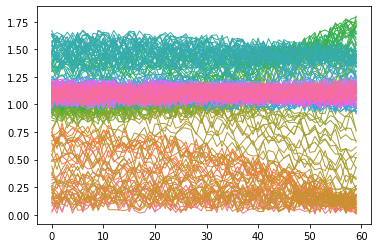

In [2]:
spectra_sequence = np.genfromtxt(os.path.join(os.path.dirname(mcr_const.__file__), "..", "data", "spectra_2_noisy_sequence.csv"))

plt.figure()
sns.set_palette('husl', spectra_sequence.shape[0])
for spec in spectra_sequence:
    plt.plot(spec, lw=1.0)
    
plt.figure()
sns.set_palette('husl', spectra_sequence.shape[1])
for line in spectra_sequence.T:
    plt.plot(line, lw=1.0)

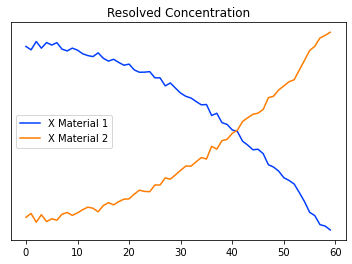

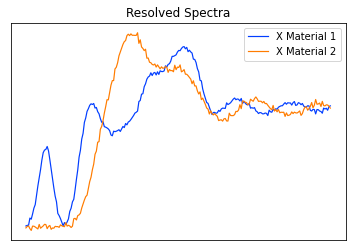

In [3]:
from pymcr.mcr import McrAR
from pymcr.regressors import NNLS

mcrar = McrAR(c_regr=NNLS(), st_regr=NNLS())
spec_guess = spectra_sequence[[5, -5]]
mcrar.fit(spectra_sequence, ST=spec_guess)
noisy_conc = mcrar.C_opt_
noisy_spec = mcrar.ST_opt_


plt.figure()
sns.set_palette('bright', noisy_conc.shape[0])
for i, conc in enumerate(noisy_conc.T):
    plt.plot(conc, label=f'X Material {i+1}')
plt.legend()
plt.yticks([])
title = "Resolved Concentration"
plt.title(title)
plt.savefig(f'{title}.pdf', dpi=300)

plt.figure()
sns.set_palette('bright', noisy_spec.shape[0])
for i, spec in enumerate(noisy_spec):
    plt.plot(spec, lw=1.2, label=f'X Material {i+1}')
plt.legend()
plt.xticks([])
plt.yticks([])
title = "Resolved Spectra"
plt.title(title)
plt.savefig(f'{title}.pdf', dpi=300)

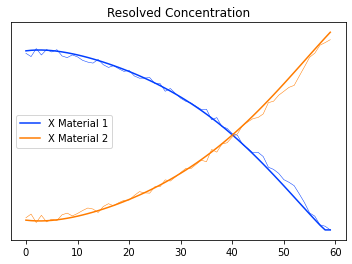

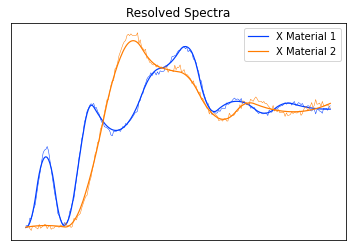

In [4]:
from pymcr.mcr import McrAR
from pymcr.regressors import NNLS
from mcr_const.constraints.nist import ConstraintSmooth, VarType


smooth_conc_1 = ConstraintSmooth.from_range(
    i_specie=0, 
    i_range=(0, spectra_sequence.shape[0]),
    exponent=5,
    smoothing_factor=0.02
)
smooth_conc_2 = ConstraintSmooth.from_range(
    i_specie=1, 
    i_range=(0, spectra_sequence.shape[0]),
    exponent=5,
    smoothing_factor=0.02
)

smooth_spec_1 = ConstraintSmooth.from_range(
    i_specie=0, 
    i_range=(0, spectra_sequence.shape[1]),
    exponent=2,
    smoothing_factor=0.1,
    var_type=VarType.SPECTRA
)
smooth_spec_2 = ConstraintSmooth.from_range(
    i_specie=1, 
    i_range=(0, spectra_sequence.shape[1]),
    exponent=2,
    smoothing_factor=0.1,
    var_type=VarType.SPECTRA
)
mcrar = McrAR(c_regr=NNLS(), st_regr=NNLS(), tol_increase=1.0,
              c_constraints=[smooth_conc_1, smooth_conc_2],
              st_constraints=[smooth_spec_1, smooth_spec_2])
spec_guess = spectra_sequence[[5, -5]]
mcrar.fit(spectra_sequence, ST=spec_guess)
resolved_conc = mcrar.C_opt_
resolved_spec = mcrar.ST_opt_


plt.figure()
colors = sns.color_palette('bright', resolved_conc.shape[0])
for i, (conc, nc, color) in enumerate(zip(resolved_conc.T, noisy_conc.T, colors)):
    plt.plot(conc, c=color, label=f'X Material {i+1}')
    plt.plot(nc, lw=0.5, c=color)
plt.legend()
plt.yticks([])
title = "Resolved Concentration"
plt.title(title)
plt.savefig(f'{title}.pdf', dpi=300)

plt.figure()
colors = sns.color_palette('bright', resolved_spec.shape[0])
for i, (spec, ns, color) in enumerate(zip(resolved_spec, noisy_spec, colors)):
    plt.plot(spec, lw=1.2, c=color, label=f'X Material {i+1}')
    plt.plot(ns, lw=0.5, c=color)
plt.legend()
plt.xticks([])
plt.yticks([])
title = "Resolved Spectra"
plt.title(title)
plt.savefig(f'{title}.pdf', dpi=300)